# Partie 3 : Visualisation des données
## `20newsgroups` **sans** stopwords

In [17]:
import ollama

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
from matplotlib import cm # 3D

import time

import sys
sys.path.append('../') 

from iads import Classifiers as classif
from iads import utils as ut
from iads import evaluation as ev
from iads import Clustering as clust

# Vectorisation des docs avec BoW (binaire ou non), TfIdf
from iads.vectorization import get_bow_vect, get_tfidf_vect

# Prétraitement du text 
from iads.preprocessing import get_corpus, clean_news, lemmatize_filter, add_real_labels

sns.set_theme()
plt.rcParams['font.family'] = 'Proxima Nova'

from scipy.sparse import csr_array

%load_ext autoreload
%autoreload 2
%matplotlib inline

from sklearn.preprocessing import normalize
from wordcloud import WordCloud
from sklearn.decomposition import PCA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Chargement des données et prétraitement

In [2]:
newsgroups_df = pd.read_csv("data/20newsgroups.csv")

np.random.seed(1)
newsgroups_df = newsgroups_df.groupby("target").sample(frac=0.1)

stop_words_df = pd.read_csv("data/stopwords.csv")
stopwords = stop_words_df["stopword"].values.tolist()

In [3]:
news_no_stopwords = clean_news(newsgroups_df, stopwords, True, True)
news_no_stopwords = add_real_labels(lemmatize_filter(news_no_stopwords, 3, 10))
corpus = get_corpus(news_no_stopwords)

Number of Nans 48


In [178]:
def distribution_target(true_targets: np.ndarray, assigned_clusters: np.ndarray, true_labels: np.ndarray):
    """Affiche la distribution des targets dans les clusters obtenus"""

    actual_pd = pd.Categorical(true_targets, categories=np.unique(true_targets))

    clusters, nb_points = np.unique(assigned_clusters, return_counts=True)
    pred_pd = pd.Categorical(assigned_clusters, categories=clusters)

    conf = pd.crosstab(actual_pd, pred_pd,
                       normalize=False,
                       colnames=["Clusters obtenus"],
                       rownames=["Nombre d'éléments d'un cluster d'origine"],
                       dropna=False)
    
    # Mettre les vrais labels sur l'axe de y
    conf.index = np.unique(true_labels)
    
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(conf, annot=True,fmt='d', cmap='Blues', cbar=False)

    # Mettre en haut le nombre de points par cluster
    for i, cluster in enumerate(conf.columns):
        count = nb_points[cluster]
        ax.text(x=i + 0.5, y=-0.5, s=str(count), ha='center', va='bottom', fontsize=12)
    
    ax.annotate("Nombre de points par cluster :", xy=(-0.15, 1.025), xycoords="axes fraction", ha='center', va='bottom', fontsize=12)
    ax.set_title("Distribution des labels par cluster", pad=30, fontsize=13)
    plt.tight_layout()
    plt.show()
    return fig

def predict_label(affectation: dict)-> list:
    """Renvoie les labels prédit par l'affectation k-means pour chaque exemple"""
    
    aff = [(i,cluster) for cluster, ids in affectation.items() for i in ids]
    indices, clusters = zip(*aff)

    cluster_labels = np.full(max(indices) + 1, -1, dtype=int) # list size of labels 

    cluster_labels[list(indices)] = list(clusters)
    return cluster_labels


def get_n_components_PCA(vectors:csr_array, explained_var:float) -> int:
    """Get a number of parameters for PCA to explain 'explained_var'"""
    model = PCA()
    model.fit(vectors)
    cumsum_var = model.explained_variance_ratio_.cumsum()
    index = np.argmax(cumsum_var >= explained_var)
    print(cumsum_var[:index+1])
    return index + 1

def plot_clusters_wordcloud(news, clusters_labels, stopwords):
    fig, axes = plt.subplots(4, 5, figsize=(15, 8)) 
    axes = axes.flatten()

    n_clusters = 20
    for i in range(n_clusters):
        ax = axes[i]
        
        text = " ".join(news[clusters_labels== i]['messages'].values.flatten())
        wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=100).generate(text)
        
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f'Cluster {i}', fontsize=18)

    plt.tight_layout()
    plt.show()
    return fig

def plot_cluster_info(M, U, centroids):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    clusters, counts = np.unique(U, return_counts=True)
    sns.pointplot(counts, ax=ax1)
    ax1.set_title("Nombre de points par cluster")

    mean_dist = []
    distances_to_centroids = np.linalg.norm(centroids[U, :] - M, axis=1)
    for cluster in clusters:
        mask = (U == cluster)
        mean_dist.append(np.mean(distances_to_centroids[mask]))
    sns.pointplot(mean_dist, ax=ax2)
    ax2.set_title("Distance moyenne de centroide dans le cluster")

def plot_3d_pca(M, U, random_state=None, title=""):
    model = PCA(3, random_state=random_state)
    proj = model.fit_transform(M)

    palette = sns.color_palette("tab20")
    fig = plt.figure(figsize=(8, 8))
    fig.patch.set_facecolor('white')  # Remove gray background

    ax = fig.add_subplot(111, projection='3d')

    data = pd.DataFrame(data={"x":proj[:, 0], "y":proj[:, 1], "z":proj[:, 2], "cluster":U})
    colors = [palette[t] for t in data["cluster"].values]

    ax.scatter(data["x"], data["y"], data["z"], c=colors, s=10, alpha=0.8)

    handles = [Patch(color=color, label=str(cluster)) for cluster, color in zip(np.unique(U), palette)]
    ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0, title="Clusters")

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.3, box.height * 0.3])

    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.set_pane_color((1.0, 1.0, 1.0, 0.0))  # Transparent

    ax.set_title(title)
    plt.tight_layout()
    return fig

In [49]:
# n_components for PCA to explain 95% of variance
# BoW Freq PCA = 336. If normalized PCA = 1109
# Bow binary PCA = 906.If normalized PCA = 1132
# Tf Idf PCA = 322. If normalized PCA = 1249
M = normalize(get_tfidf_vect(news_no_stopwords, corpus))
get_n_components_PCA(M, 0.95)

KeyboardInterrupt: 

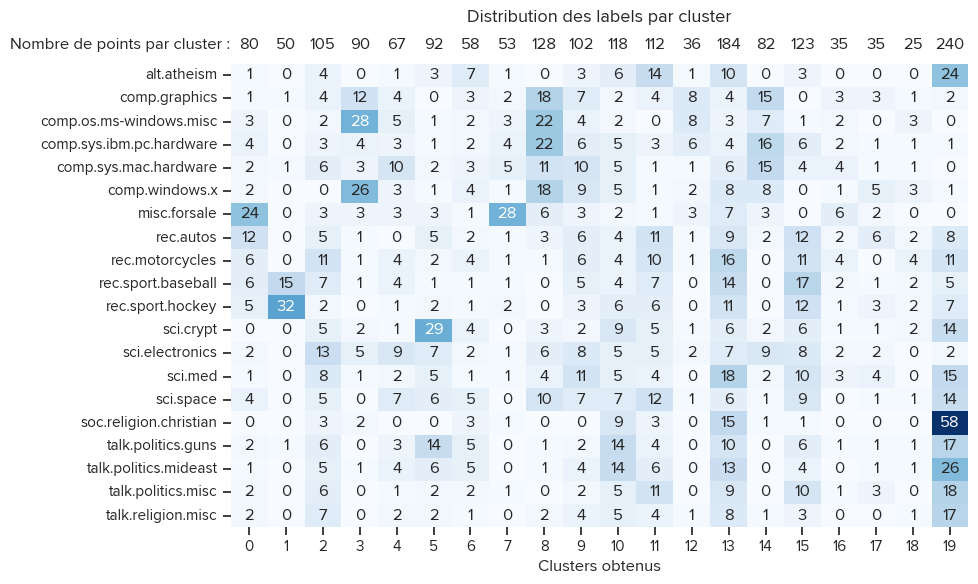

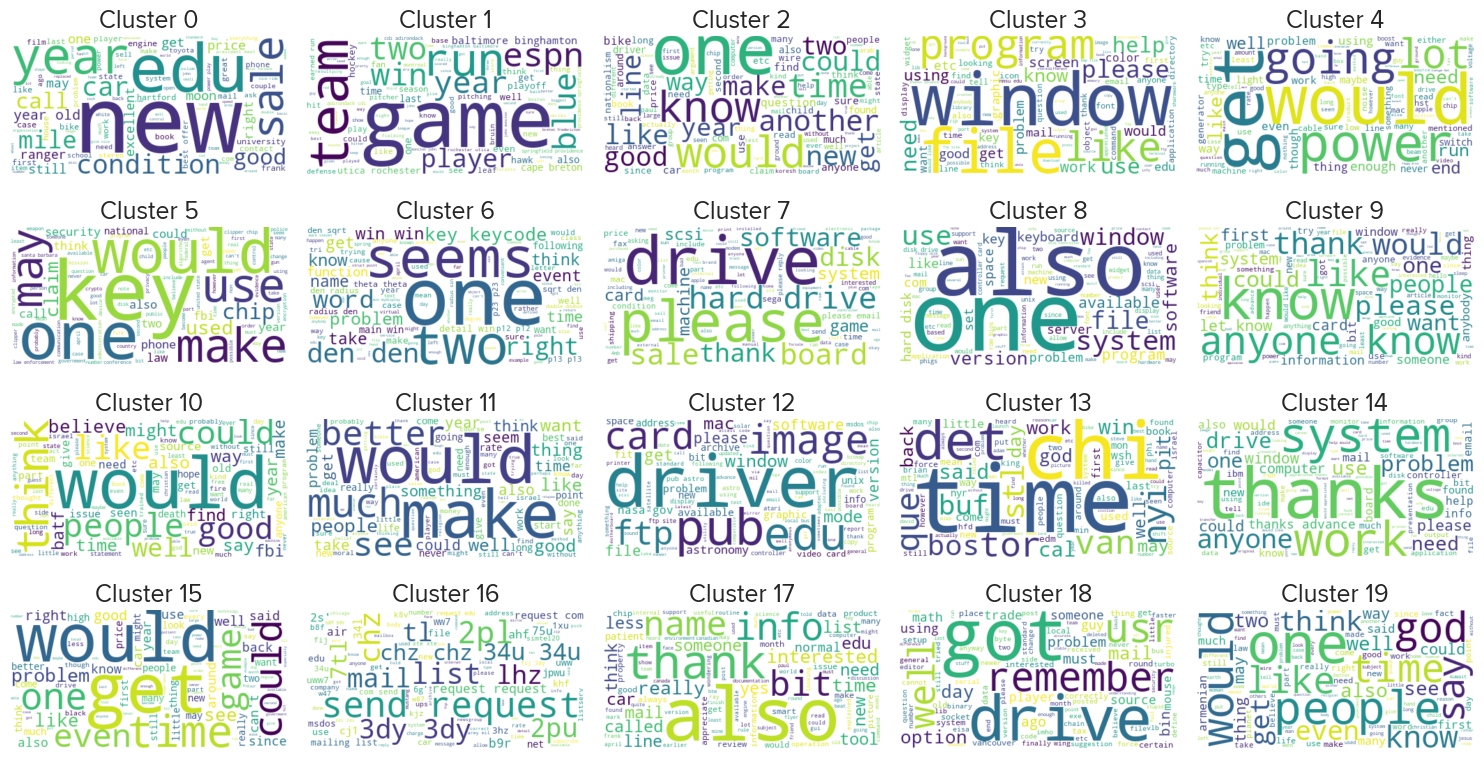

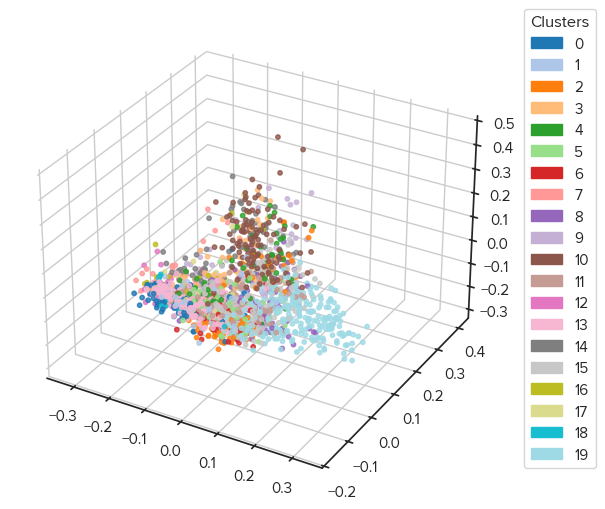

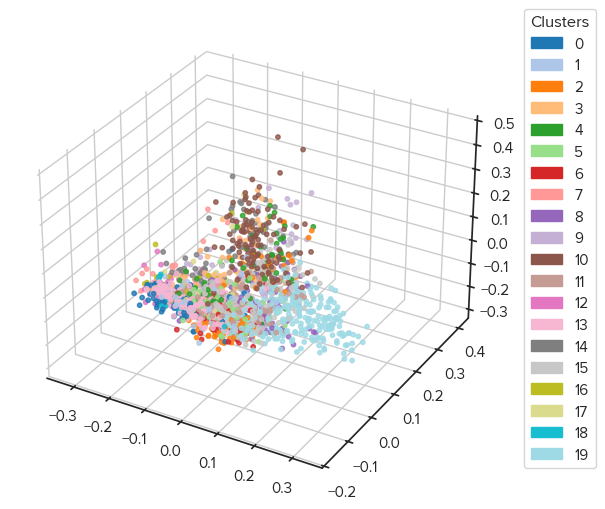

In [ ]:
from matplotlib.patches import Patch

random.seed(1)
np.random.seed(1)
M = normalize(get_bow_vect(news_no_stopwords, corpus, binary=True))

# PCA dimensionality reduction
model = PCA(n_components=1132, random_state=1)
m_pca = model.fit_transform(M)

# KMeans
centroids, U = clust.kmoyennes(20, m_pca, 0, 300, verbose=False)
U = predict_label(U)

sns.set_theme(style="ticks")
plt.rcParams['font.family'] = 'Proxima Nova'

fig1=distribution_target(news_no_stopwords["target"].values, U, news_no_stopwords["label"].values)
#plot_cluster_info(m_pca, U, centroids)
fig2=plot_clusters_wordcloud(news_no_stopwords, U, stopwords)

fig3=plot_3d_pca(m_pca, U, 1)
fig1.savefig("images/no_sw/bow_bin_labels_distr", dpi=150, bbox_inches='tight')
fig2.savefig("images/no_sw/bow_bin_wordcloud", dpi=150, bbox_inches='tight')
fig3.savefig("images/no_sw/bow_bin_pca", dpi=150, bbox_inches='tight')

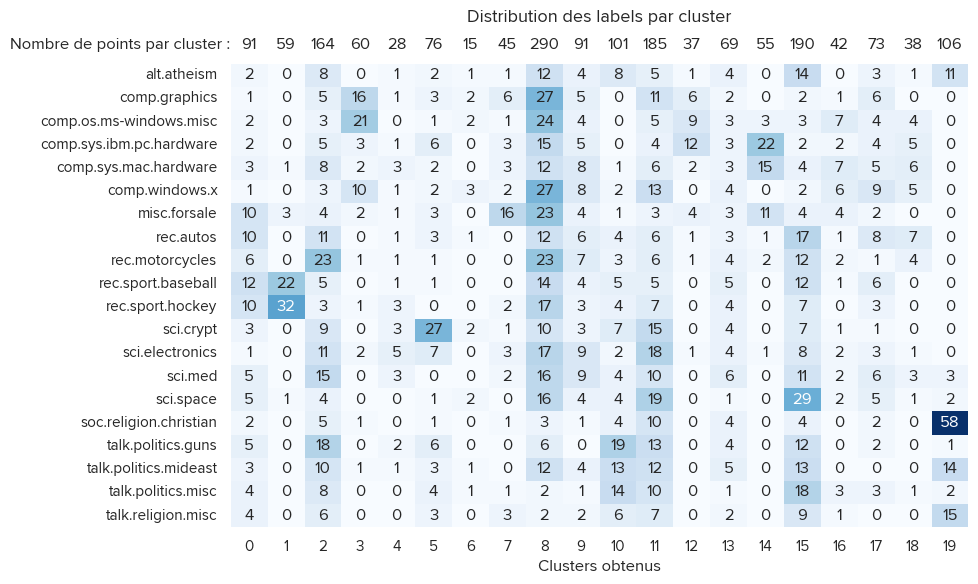

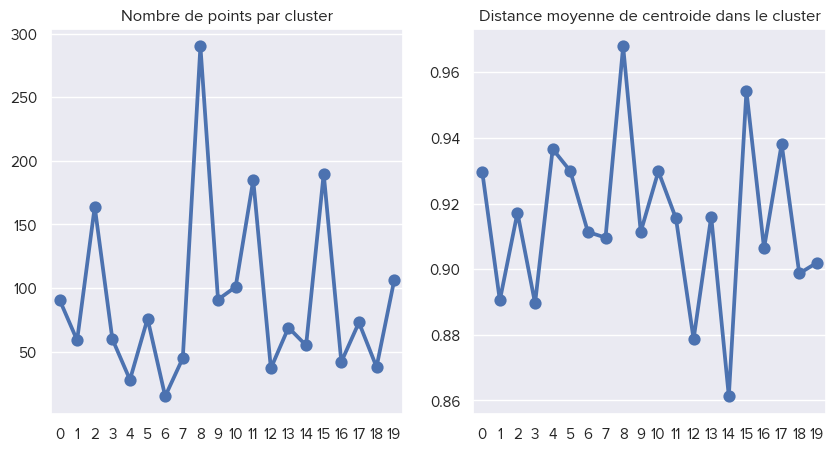

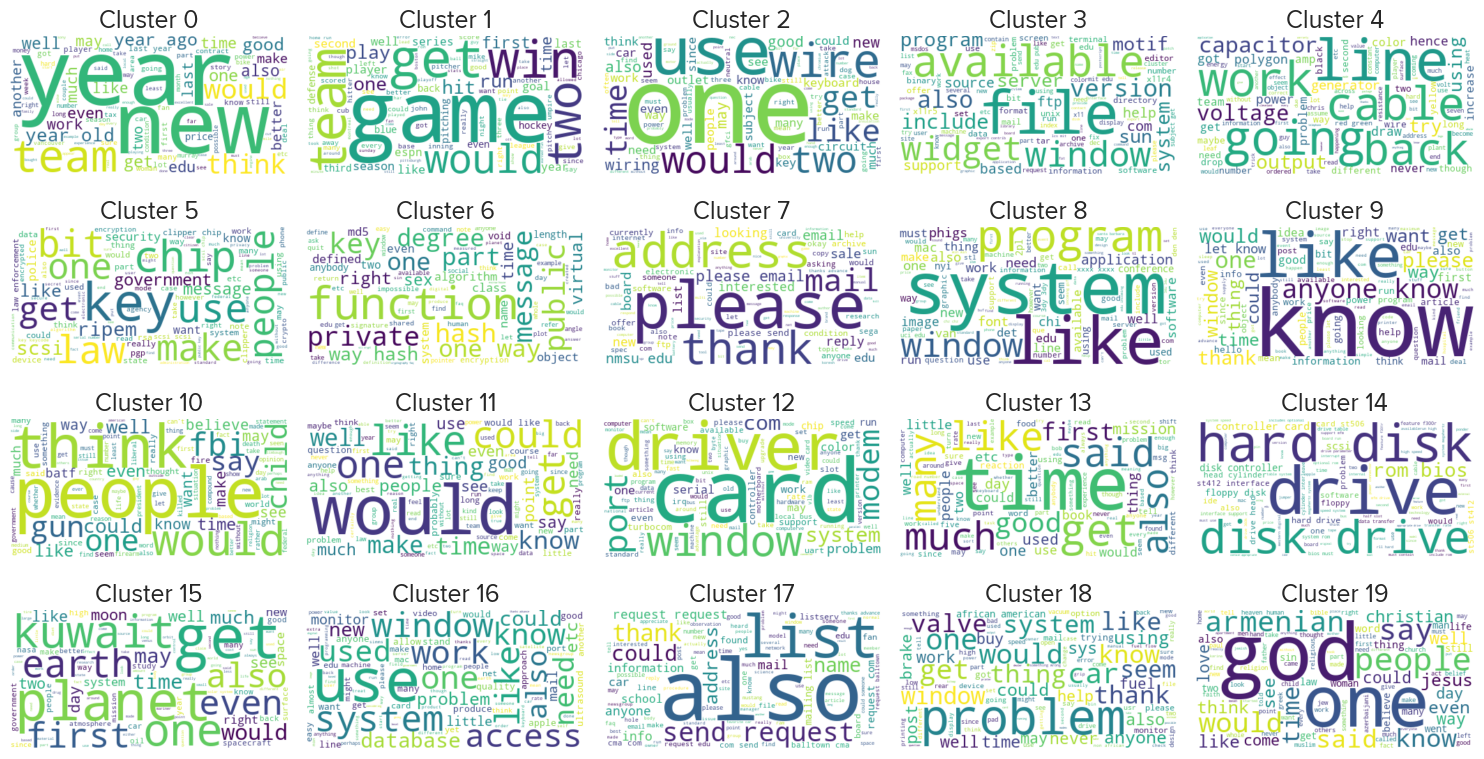

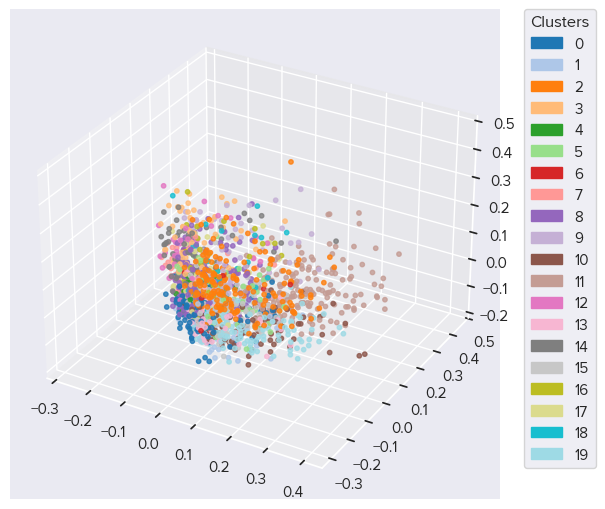

In [143]:
random.seed(1)
np.random.seed(1)
M = normalize(get_bow_vect(news_no_stopwords, corpus, binary=False))

# PCA dimensionality reduction
model = PCA(n_components=1109, random_state=1)
m_pca = model.fit_transform(M)

# KMeans
centroids, U = clust.kmoyennes(20, m_pca, 0, 300, verbose=False)
U = predict_label(U)

distribution_target(news_no_stopwords["target"].values, U, news_no_stopwords["label"].values)
plot_cluster_info(m_pca, U, centroids)
plot_clusters_wordcloud(news_no_stopwords, U, stopwords)

plot_3d_pca(m_pca, U, 1)

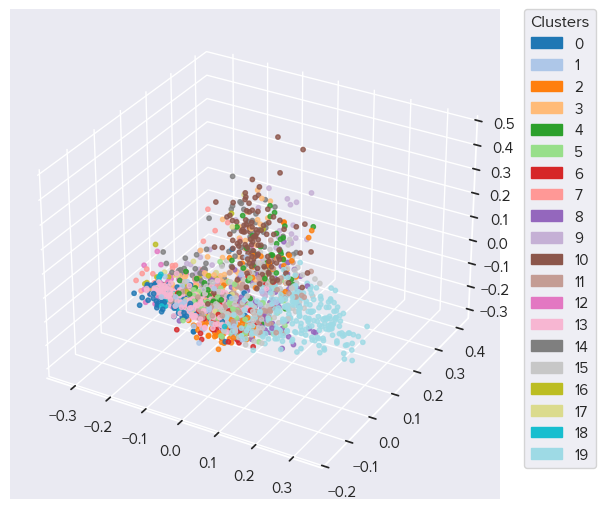

In [147]:
plot_3d_pca(m_pca, U, 1)

### Tf-Idf

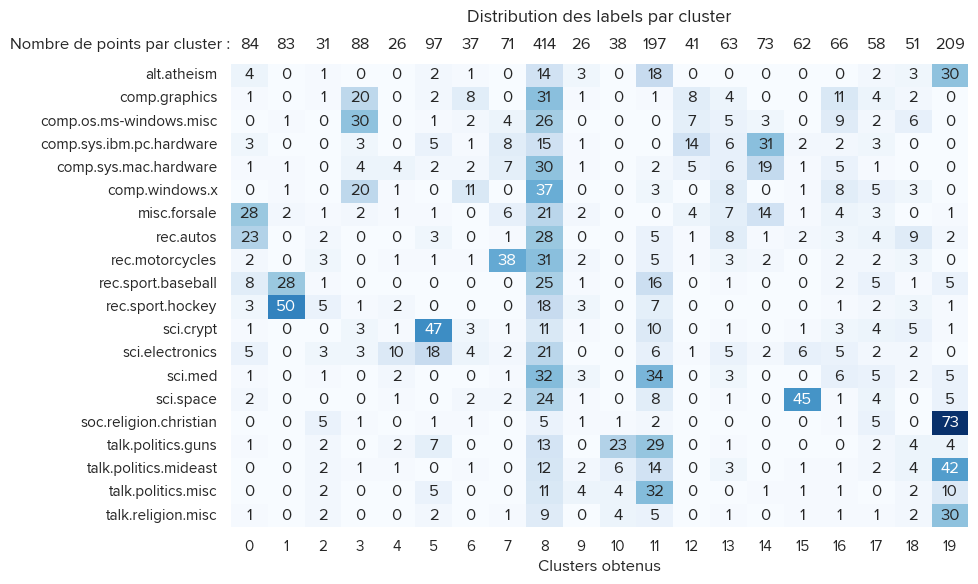

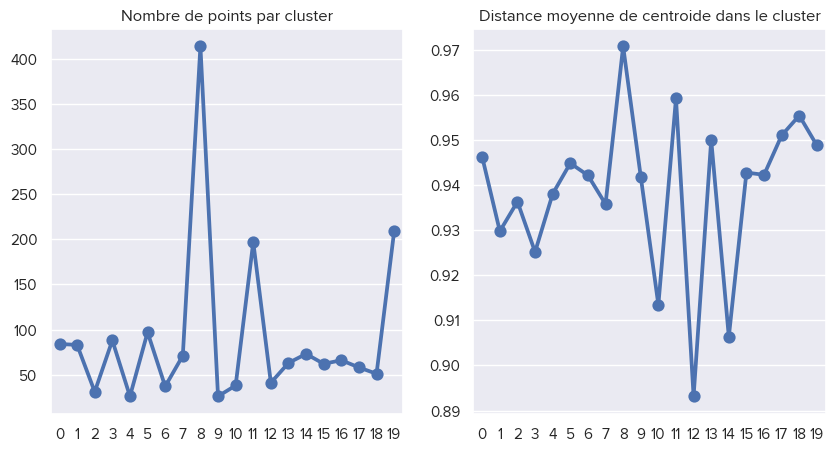

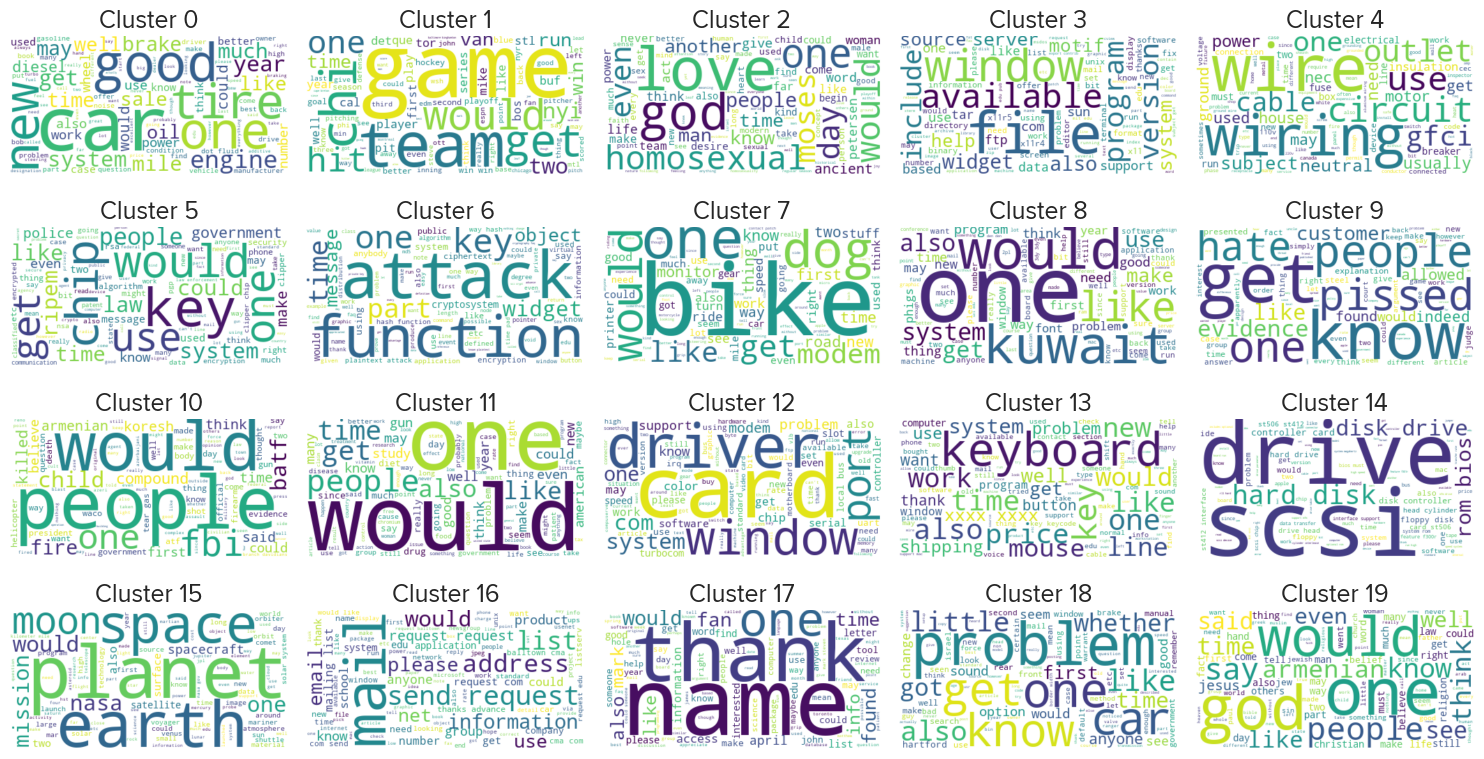

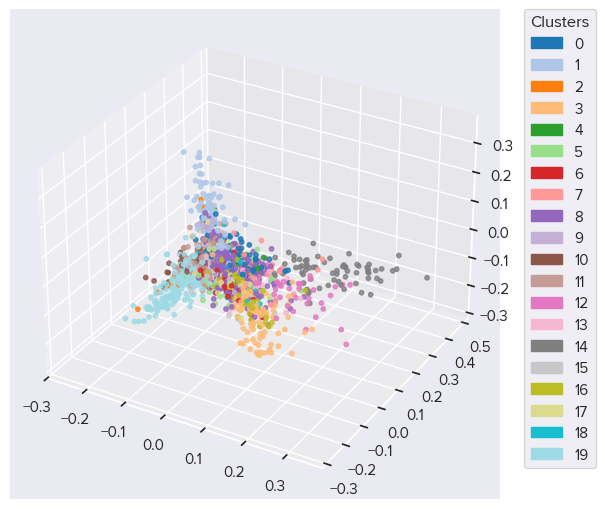

In [144]:
random.seed(1)
np.random.seed(1)

M = normalize(get_tfidf_vect(news_no_stopwords, corpus))

# PCA dimensionality reduction
model = PCA(n_components=1249, random_state=1)
m_pca = model.fit_transform(M)

# KMeans

centroids, U = clust.kmoyennes(20, m_pca, 0, 1000, verbose=False)
U = predict_label(U)

#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
distribution_target(news_no_stopwords["target"].values, U, news_no_stopwords["label"].values)
plot_cluster_info(m_pca, U, centroids)
plot_clusters_wordcloud(news_no_stopwords, U, stopwords)

plot_3d_pca(m_pca, U, 1)